
# 🎬 Movies Data Analysis using PySpark

This notebook analyzes `movies_dataset.csv` using **PySpark**.

It performs:
- Data loading & cleaning
- Genre analysis
- Rating statistics
- Director ranking
- Yearly trends & rating distribution

Adjust file paths and column names as needed.


In [35]:

from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, count, when, isnan, lit, split, explode, trim, lower,
    avg, desc, year as spark_year, to_date, regexp_replace, round as spark_round
)
import os

# ---------- Configuration ----------
INPUT_CSV = 'C:\\Users\\91996\\Desktop\\Bhanu_Bda\\movies_dataset.csv'  # Path to your dataset
OUTPUT_DIR = 'C:\\Users\\91996\\Desktop\\Bhanu_Bda'

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---------- Start Spark ----------
spark = SparkSession.builder.appName('MoviesDataAnalysis').getOrCreate()
spark.sparkContext.setLogLevel('WARN')


In [21]:

print(f"Loading data from: {INPUT_CSV}")
df = spark.read.options(header=True, inferSchema=True, multiLine=True, escape='"').csv(INPUT_CSV)

print('Schema:')
df.printSchema()

print('First 5 rows:')
df.show(5, truncate=False)


Loading data from: C:\Users\91996\Desktop\Bhanu_Bda\movies_dataset.csv
Schema:
root
 |-- MovieID: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Genre: string (nullable = true)
 |-- ReleaseYear: integer (nullable = true)
 |-- ReleaseDate: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- BudgetUSD: double (nullable = true)
 |-- US_BoxOfficeUSD: double (nullable = true)
 |-- Global_BoxOfficeUSD: double (nullable = true)
 |-- Opening_Day_SalesUSD: double (nullable = true)
 |-- One_Week_SalesUSD: double (nullable = true)
 |-- IMDbRating: double (nullable = true)
 |-- RottenTomatoesScore: integer (nullable = true)
 |-- NumVotesIMDb: integer (nullable = true)
 |-- NumVotesRT: integer (nullable = true)
 |-- Director: string (nullable = true)
 |-- LeadActor: string (nullable = true)

First 5 rows:
+-------+----------------------------+-----------+-----------+-----------+-------+----------+---------------+-------------------+--------------------+--------

In [22]:
from pyspark.sql.functions import col, count, when, isnan
from pyspark.sql.types import StringType, NumericType

# Print basic info
print('Row count:', df.count())
print('Column list:', df.columns)

# Separate string and numeric columns
string_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, StringType)]
numeric_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, NumericType)]

# For string columns: check for null or empty string
string_exprs = [count(when(col(c).isNull() | (col(c) == ''), c)).alias(c) for c in string_cols]

# For numeric columns: check for null or NaN
numeric_exprs = [count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in numeric_cols]

# Combine both
missing_counts = df.select(string_exprs + numeric_exprs)
missing_counts.show(truncate=False)


Row count: 999999
Column list: ['MovieID', 'Title', 'Genre', 'ReleaseYear', 'ReleaseDate', 'Country', 'BudgetUSD', 'US_BoxOfficeUSD', 'Global_BoxOfficeUSD', 'Opening_Day_SalesUSD', 'One_Week_SalesUSD', 'IMDbRating', 'RottenTomatoesScore', 'NumVotesIMDb', 'NumVotesRT', 'Director', 'LeadActor']
+-----+-----+-----------+-------+--------+---------+-------+-----------+---------+---------------+-------------------+--------------------+-----------------+----------+-------------------+------------+----------+
|Title|Genre|ReleaseDate|Country|Director|LeadActor|MovieID|ReleaseYear|BudgetUSD|US_BoxOfficeUSD|Global_BoxOfficeUSD|Opening_Day_SalesUSD|One_Week_SalesUSD|IMDbRating|RottenTomatoesScore|NumVotesIMDb|NumVotesRT|
+-----+-----+-----------+-------+--------+---------+-------+-----------+---------+---------------+-------------------+--------------------+-----------------+----------+-------------------+------------+----------+
|0    |0    |0          |0      |0       |0        |0      |0      

In [23]:

df = df.dropDuplicates()
string_cols = [f.name for f in df.schema.fields if f.dataType.simpleString() == 'string']
for sc in string_cols:
    df = df.withColumn(sc, trim(col(sc)))

for old in df.columns:
    new = old.strip().lower().replace(' ', '_')
    if new != old:
        df = df.withColumnRenamed(old, new)

print('Columns after normalization:')
print(df.columns)


Columns after normalization:
['movieid', 'title', 'genre', 'releaseyear', 'releasedate', 'country', 'budgetusd', 'us_boxofficeusd', 'global_boxofficeusd', 'opening_day_salesusd', 'one_week_salesusd', 'imdbrating', 'rottentomatoesscore', 'numvotesimdb', 'numvotesrt', 'director', 'leadactor']


In [24]:

cols = set(df.columns)

col_title = next((c for c in cols if c in ('title', 'movie_title', 'name')), None)
col_genres = next((c for c in cols if 'genre' in c), None)
col_director = next((c for c in cols if 'director' in c), None)
col_rating = next((c for c in cols if c in ('vote_average', 'rating', 'avg_rating', 'score')), None)
col_votes = next((c for c in cols if c in ('vote_count', 'votes', 'num_votes')), None)
col_release = next((c for c in cols if c in ('release_date', 'released', 'year', 'release_year')), None)

print('Detected mapping:')
print('title ->', col_title)
print('genres ->', col_genres)
print('director ->', col_director)
print('rating ->', col_rating)
print('votes ->', col_votes)
print('release ->', col_release)


Detected mapping:
title -> title
genres -> genre
director -> director
rating -> None
votes -> None
release -> None


In [25]:

if col_genres:
    df = df.withColumn(col_genres, regexp_replace(col(col_genres), '\\|', ','))
    df = df.withColumn(col_genres, regexp_replace(col(col_genres), ';', ','))
    df = df.withColumn(col_genres, regexp_replace(col(col_genres), '\\s*,\\s*', ','))

    genres_exploded = df.withColumn('genre', explode(split(col(col_genres), ','))).withColumn('genre', trim(lower(col('genre'))))
    genres_exploded = genres_exploded.filter(col('genre') != '')

    top_genres = genres_exploded.groupBy('genre').agg(count('*').alias('movie_count')).orderBy(desc('movie_count'))
    top_genres.show(20, truncate=False)
else:
    print('No genres column detected.')


+-----------+-----------+
|genre      |movie_count|
+-----------+-----------+
|drama      |250018     |
|comedy     |199832     |
|action     |150131     |
|thriller   |100071     |
|romance    |100021     |
|horror     |100010     |
|documentary|50114      |
|sci-fi     |49802      |
+-----------+-----------+



In [29]:

if col_rating:
    rating_col = col(col_rating)
    df.select(spark_round(avg(rating_col), 3).alias('mean_rating')).show()

    if col_votes:
        top_by_votes_and_rating = df.select(col_title or lit('UNKNOWN').alias('title'), col_rating, col_votes).filter(col(col_votes).isNotNull()).orderBy(desc(col_rating), desc(col_votes))
        top_by_votes_and_rating.show(20, truncate=False)
    else:
        top_by_rating = df.select(col_title or lit('UNKNOWN').alias('title'), col_rating).orderBy(desc(col_rating))
        top_by_rating.show(20, truncate=False)


In [30]:

if col_director:
    directors_processed = df.withColumn(col_director, regexp_replace(col(col_director), '\\s*\\&\\s*', ','))
    directors_processed = directors_processed.withColumn(col_director, regexp_replace(col(col_director), ';', ','))
    directors_exploded = directors_processed.withColumn('director', explode(split(col(col_director), ','))).withColumn('director', trim(col('director')))
    top_directors = directors_exploded.groupBy('director').agg(count('*').alias('movie_count')).orderBy(desc('movie_count'))
    top_directors.show(20, truncate=False)
else:
    print('No director column detected.')


+-----------------+-----------+
|director         |movie_count|
+-----------------+-----------+
|Tara Underwood   |6898       |
|Melissa Hernandez|6862       |
|Caitlin Brewer   |6830       |
|Brian Robinson   |6818       |
|Maria Lane       |6794       |
|Rachel Hayes     |6794       |
|Karen Robinson   |6790       |
|Francisco Ford   |6779       |
|Emily Miller     |6776       |
|Terry Lawrence   |6776       |
|Paul Weiss       |6773       |
|Alyssa Adams     |6771       |
|Manuel Benton    |6768       |
|Mary Mitchell    |6767       |
|David Charles    |6761       |
|Michael Manning  |6759       |
|Susan Farley     |6759       |
|William Walker   |6758       |
|Anthony Rowland  |6758       |
|Gary Simmons     |6757       |
+-----------------+-----------+
only showing top 20 rows


In [31]:

if col_release:
    df_with_year = df.withColumn('release_year', col(col_release).cast('int'))
    df_with_year = df_with_year.withColumn('release_year', when(col('release_year').isNull(), spark_year(to_date(col(col_release), 'yyyy-MM-dd'))).otherwise(col('release_year')))
    df_with_year = df_with_year.withColumn('release_year', when(col('release_year').isNull(), spark_year(to_date(col(col_release), 'dd-MM-yyyy'))).otherwise(col('release_year')))

    if 'release_year' in df_with_year.columns:
        year_counts = df_with_year.groupBy('release_year').agg(count('*').alias('movie_count')).orderBy('release_year')
        year_counts.show(30, truncate=False)

        if col_rating:
            rating_by_year = df_with_year.groupBy('release_year').agg(spark_round(avg(col(col_rating)), 3).alias('avg_rating'), count('*').alias('movie_count')).orderBy('release_year')
            rating_by_year.show(30, truncate=False)
else:
    print('No release/date/year column detected.')


No release/date/year column detected.


In [32]:

if col_rating:
    rcol = col(col_rating)
    buckets = df.select(
        when((rcol >= 0) & (rcol < 2), '0-2')
        .when((rcol >= 2) & (rcol < 4), '2-4')
        .when((rcol >= 4) & (rcol < 6), '4-6')
        .when((rcol >= 6) & (rcol < 8), '6-8')
        .when((rcol >= 8) & (rcol <= 10), '8-10')
        .otherwise('unknown')
        .alias('rating_bucket')
    )
    bucket_counts = buckets.groupBy('rating_bucket').agg(count('*').alias('count')).orderBy('rating_bucket')
    bucket_counts.show(truncate=False)


In [34]:

spark.stop()
print('✅ Finished movies analysis.')


✅ Finished movies analysis.


In [36]:

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, isnan

# Initialize Spark session
spark = SparkSession.builder.appName("MoviesAnalysis").getOrCreate()

# Load dataset
file_path = "C:\\Users\\91996\\Desktop\\Bhanu_Bda\\movies_dataset.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)
print("✅ Data loaded successfully")
print("Row count:", df.count())
print("Columns:", df.columns)


✅ Data loaded successfully
Row count: 999999
Columns: ['MovieID', 'Title', 'Genre', 'ReleaseYear', 'ReleaseDate', 'Country', 'BudgetUSD', 'US_BoxOfficeUSD', 'Global_BoxOfficeUSD', 'Opening_Day_SalesUSD', 'One_Week_SalesUSD', 'IMDbRating', 'RottenTomatoesScore', 'NumVotesIMDb', 'NumVotesRT', 'Director', 'LeadActor']


In [37]:

from pyspark.sql.types import StringType, NumericType

string_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, StringType)]
numeric_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, NumericType)]

string_exprs = [count(when(col(c).isNull() | (col(c) == ''), c)).alias(c) for c in string_cols]
numeric_exprs = [count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in numeric_cols]

missing_counts = df.select(string_exprs + numeric_exprs)
missing_counts.show(truncate=False)


+-----+-----+-----------+-------+--------+---------+-------+-----------+---------+---------------+-------------------+--------------------+-----------------+----------+-------------------+------------+----------+
|Title|Genre|ReleaseDate|Country|Director|LeadActor|MovieID|ReleaseYear|BudgetUSD|US_BoxOfficeUSD|Global_BoxOfficeUSD|Opening_Day_SalesUSD|One_Week_SalesUSD|IMDbRating|RottenTomatoesScore|NumVotesIMDb|NumVotesRT|
+-----+-----+-----------+-------+--------+---------+-------+-----------+---------+---------------+-------------------+--------------------+-----------------+----------+-------------------+------------+----------+
|0    |0    |0          |0      |0       |0        |0      |0          |0        |0              |0                  |0                   |0                |0         |0                  |0           |0         |
+-----+-----+-----------+-------+--------+---------+-------+-----------+---------+---------------+-------------------+--------------------+---------

In [38]:

from pyspark.sql.functions import when

# Genre count
df_genre_count = df.groupBy("Genre").count().withColumnRenamed("count", "MovieCount")

# Yearly trend
df_year_trend = df.groupBy("ReleaseYear").count().withColumnRenamed("count", "MovieCount")

# Rating buckets
df_rating_buckets = df.withColumn(
    "RatingBucket",
    when(col("IMDbRating") >= 8, "8+")
    .when(col("IMDbRating") >= 6, "6–8")
    .otherwise("<6")
).groupBy("RatingBucket").count()

# Director analysis
df_directors = df.groupBy("Director").count().withColumnRenamed("count", "MovieCount")

print("✅ Analysis DataFrames created successfully")


✅ Analysis DataFrames created successfully


In [39]:

# Install visualization libraries if missing
import sys
!{sys.executable} -m pip install seaborn matplotlib --quiet



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [40]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert PySpark DataFrames to Pandas
genre_pdf = df_genre_count.toPandas()
year_trend_pdf = df_year_trend.toPandas()
rating_buckets_pdf = df_rating_buckets.toPandas()
directors_pdf = df_directors.toPandas()

sns.set(style="whitegrid", palette="muted")
print("✅ DataFrames converted to Pandas for visualization.")


✅ DataFrames converted to Pandas for visualization.


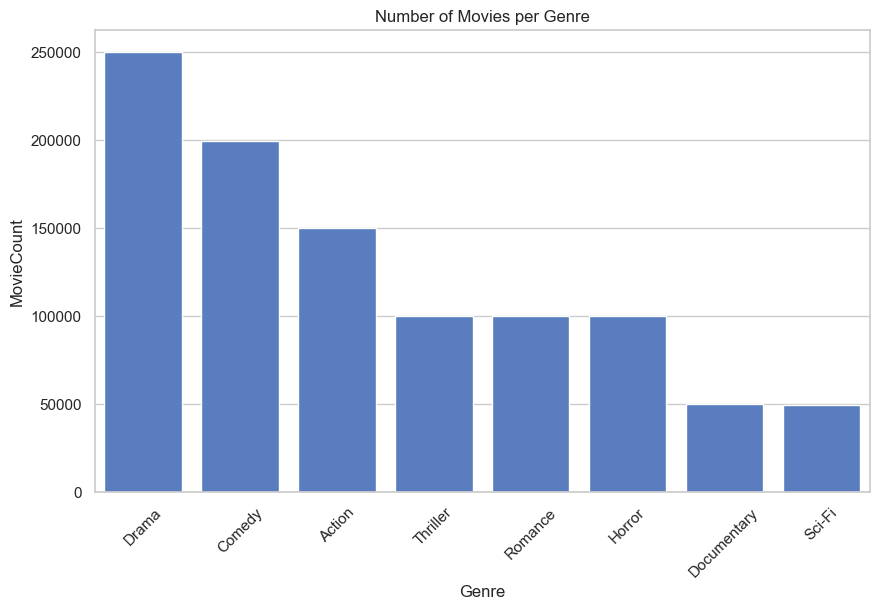

In [41]:

# 1️⃣ Genre Popularity
plt.figure(figsize=(10,6))
sns.barplot(x='Genre', y='MovieCount', data=genre_pdf.sort_values('MovieCount', ascending=False))
plt.title('Number of Movies per Genre')
plt.xticks(rotation=45)
plt.show()


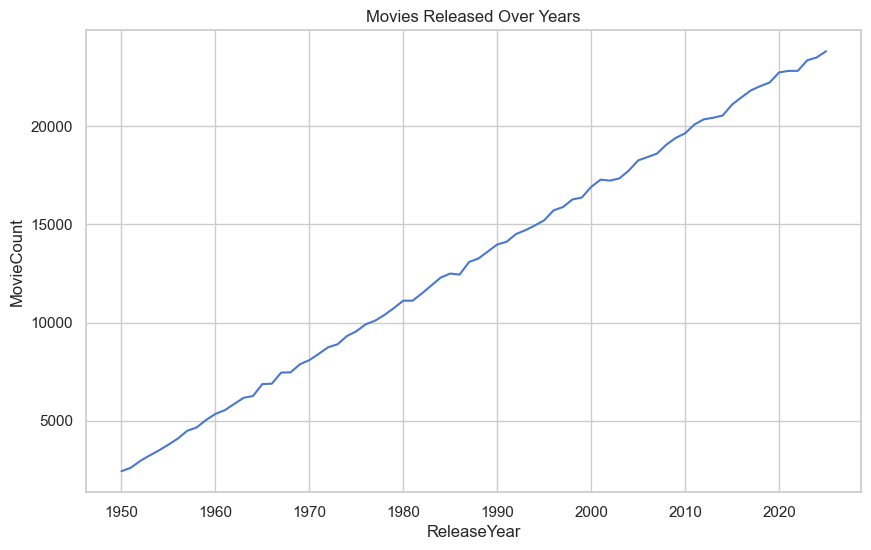

In [42]:

# 2️⃣ Movie Count by Year
plt.figure(figsize=(10,6))
sns.lineplot(x='ReleaseYear', y='MovieCount', data=year_trend_pdf)
plt.title('Movies Released Over Years')
plt.show()


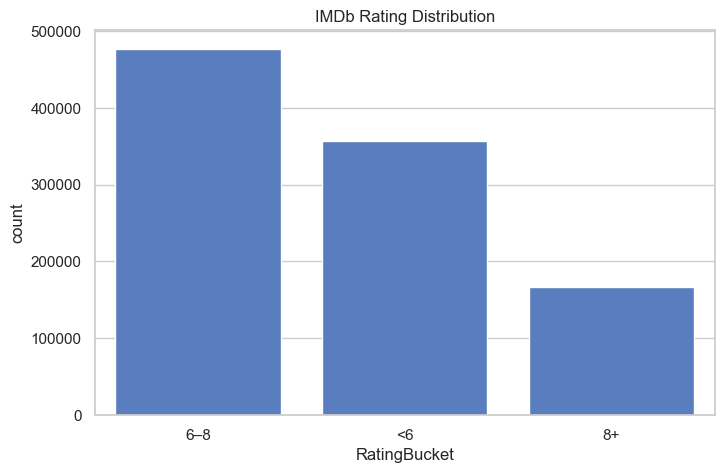

In [43]:

# 3️⃣ IMDb Rating Distribution
plt.figure(figsize=(8,5))
sns.barplot(x='RatingBucket', y='count', data=rating_buckets_pdf)
plt.title('IMDb Rating Distribution')
plt.show()


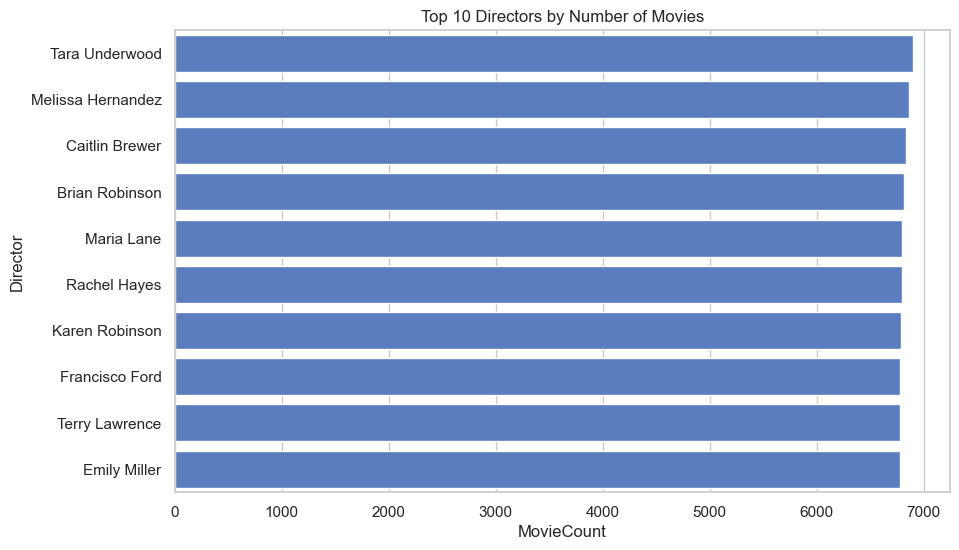

In [44]:

# 4️⃣ Top 10 Directors by Number of Movies
top10_directors = directors_pdf.sort_values('MovieCount', ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(y='Director', x='MovieCount', data=top10_directors)
plt.title('Top 10 Directors by Number of Movies')
plt.show()


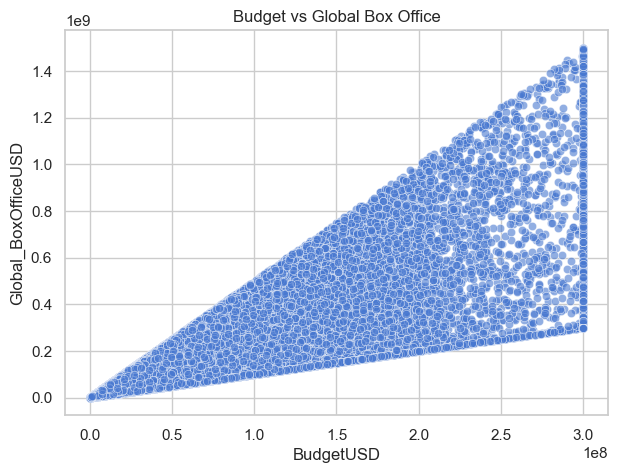

In [45]:

# 5️⃣ Budget vs Global Box Office (if numeric columns exist)
from pyspark.sql.functions import col
cols = df.columns
if 'BudgetUSD' in cols and 'Global_BoxOfficeUSD' in cols:
    numeric_pdf = df.select("BudgetUSD", "Global_BoxOfficeUSD").toPandas()
    plt.figure(figsize=(7,5))
    sns.scatterplot(x='BudgetUSD', y='Global_BoxOfficeUSD', data=numeric_pdf, alpha=0.6)
    plt.title('Budget vs Global Box Office')
    plt.show()
else:
    print("⚠️ Columns 'BudgetUSD' or 'Global_BoxOfficeUSD' not found, skipping scatter plot.")
